# Model 1 With Transfer Learning with Mobilenetv2

## Import Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tensorflow.keras import models, layers, optimizers, losses, metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os
from pathlib import Path
import random
from sklearn.metrics import confusion_matrix

IMPORT DATASET WITH gdown

In [ ]:
import gdown
url = 'https://drive.google.com/uc?id=1gbzEkvoPiBoqLUVug-H8BmdvGZjoy2wr'

output = 'skin-disease-datasaet.zip'

gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1gbzEkvoPiBoqLUVug-H8BmdvGZjoy2wr
To: /content/skin-disease-datasaet.zip
100%|██████████| 22.5M/22.5M [00:00<00:00, 136MB/s] 


'skin-disease-datasaet.zip'

## Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
!ls drive/MyDrive/Dataset/

ls: cannot access 'drive/MyDrive/Dataset/': No such file or directory


In [ ]:
!unzip /content/skin-disease-datasaet.zip

Archive:  /content/skin-disease-datasaet.zip
   creating: skin-disease-datasaet/
   creating: skin-disease-datasaet/test_set/
   creating: skin-disease-datasaet/test_set/BA- cellulitis/
  inflating: skin-disease-datasaet/test_set/BA- cellulitis/BA- cellulitis (1).webp  
  inflating: skin-disease-datasaet/test_set/BA- cellulitis/BA- cellulitis (104).jpg  
  inflating: skin-disease-datasaet/test_set/BA- cellulitis/BA- cellulitis (106).jpg  
  inflating: skin-disease-datasaet/test_set/BA- cellulitis/BA- cellulitis (115).jpg  
  inflating: skin-disease-datasaet/test_set/BA- cellulitis/BA- cellulitis (119).jpg  
  inflating: skin-disease-datasaet/test_set/BA- cellulitis/BA- cellulitis (124).jpg  
  inflating: skin-disease-datasaet/test_set/BA- cellulitis/BA- cellulitis (135).jpg  
  inflating: skin-disease-datasaet/test_set/BA- cellulitis/BA- cellulitis (139).jpg  
  inflating: skin-disease-datasaet/test_set/BA- cellulitis/BA- cellulitis (144).jpg  
  inflating: skin-disease-datasaet/test_s

In [ ]:
#Directory Data
train_dir = '/content/skin-disease-datasaet/train_set'
test_dir = '/content/skin-disease-datasaet/test_set'

# Initialize counters
total_train_images = 0
total_test_images = 0

# Count images in train set
print("From train_dir")
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    num_images = len(os.listdir(category_dir))
    print(f"Train - {category}: {num_images} images")
    total_train_images += num_images
print("")

# Count images in test set
print("From test_dir")
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    num_images = len(os.listdir(category_dir))
    print(f"Test - {category}: {num_images} images")
    total_test_images += num_images
print("")

# Calculate total number of images
print(f"Total train images: {total_train_images}")
print(f"Total test images: {total_test_images}")

From train_dir
Train - FU-nail-fungus: 129 images
Train - VI-shingles: 130 images
Train - VI-chickenpox: 136 images
Train - BA-impetigo: 80 images
Train - BA- cellulitis: 136 images
Train - scar: 133 images
Train - FU-ringworm: 90 images
Train - FU-athlete-foot: 124 images
Train - PA-cutaneous-larva-migrans: 100 images

From test_dir
Test - FU-nail-fungus: 33 images
Test - VI-shingles: 33 images
Test - VI-chickenpox: 34 images
Test - BA-impetigo: 20 images
Test - BA- cellulitis: 34 images
Test - scar: 27 images
Test - FU-ringworm: 23 images
Test - FU-athlete-foot: 32 images
Test - PA-cutaneous-larva-migrans: 25 images

Total train images: 1058
Total test images: 261


## Image Data Generator

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage
from skimage.io import imread
from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR = '/content/skin-disease-datasaet/train_set'
training_datagen = ImageDataGenerator(
      rescale = 1./255)

VALIDATION_DIR = '/content/skin-disease-datasaet/test_set'
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=10
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=10
)


#Test set
X_test = []
y_test = []
labels = ['BA- cellulitis','BA-impetigo','FU-athlete-foot','FU-nail-fungus','FU-ringworm','PA-cutaneous-larva-migrans','VI-chickenpox','VI-shingles','scar']

for i, label in enumerate(labels):
    folder = os.path.join('/content/skin-disease-datasaet/test_set', label)
    files = sorted(os.listdir(folder))
    for k, file in enumerate(files):
        image_path = os.path.join(folder, file)
        image = imread(image_path) / 255.
        image = resize(image, (224, 224))
        X_test.append(image)
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

#Menampilkan bentuk dari masing-masing set
for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in validation_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)


# Check if there are any images from 'Luka'
luka_indices = [i for i, label in enumerate(y_test) if labels[label] == 'scar']
print(f'Number of Luka images in X_test: {len(luka_indices)}')

Found 1057 images belonging to 9 classes.
Found 260 images belonging to 9 classes.
Bentuk array dari dataset train (pelatihan) adalah: (10, 224, 224, 3) (10, 9)
Bentuk array dari dataset validation (validasi) adalah: (10, 224, 224, 3) (10, 9)
Bentuk array dari dataset test (pengujian) adalah: (261, 224, 224, 3) (261,)
Number of Luka images in X_test: 27


In [ ]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'BA- cellulitis': 0, 'BA-impetigo': 1, 'FU-athlete-foot': 2, 'FU-nail-fungus': 3, 'FU-ringworm': 4, 'PA-cutaneous-larva-migrans': 5, 'VI-chickenpox': 6, 'VI-shingles': 7, 'scar': 8}


## Data Visualization

In [ ]:
# Train Data Classes
classes = os.listdir(train_dir)
classes = sorted(classes)
print(f"Total classes = {len(classes)}")
print(f"Classes: {classes}")

Total classes = 9
Classes: ['BA- cellulitis', 'BA-impetigo', 'FU-athlete-foot', 'FU-nail-fungus', 'FU-ringworm', 'PA-cutaneous-larva-migrans', 'VI-chickenpox', 'VI-shingles', 'scar']


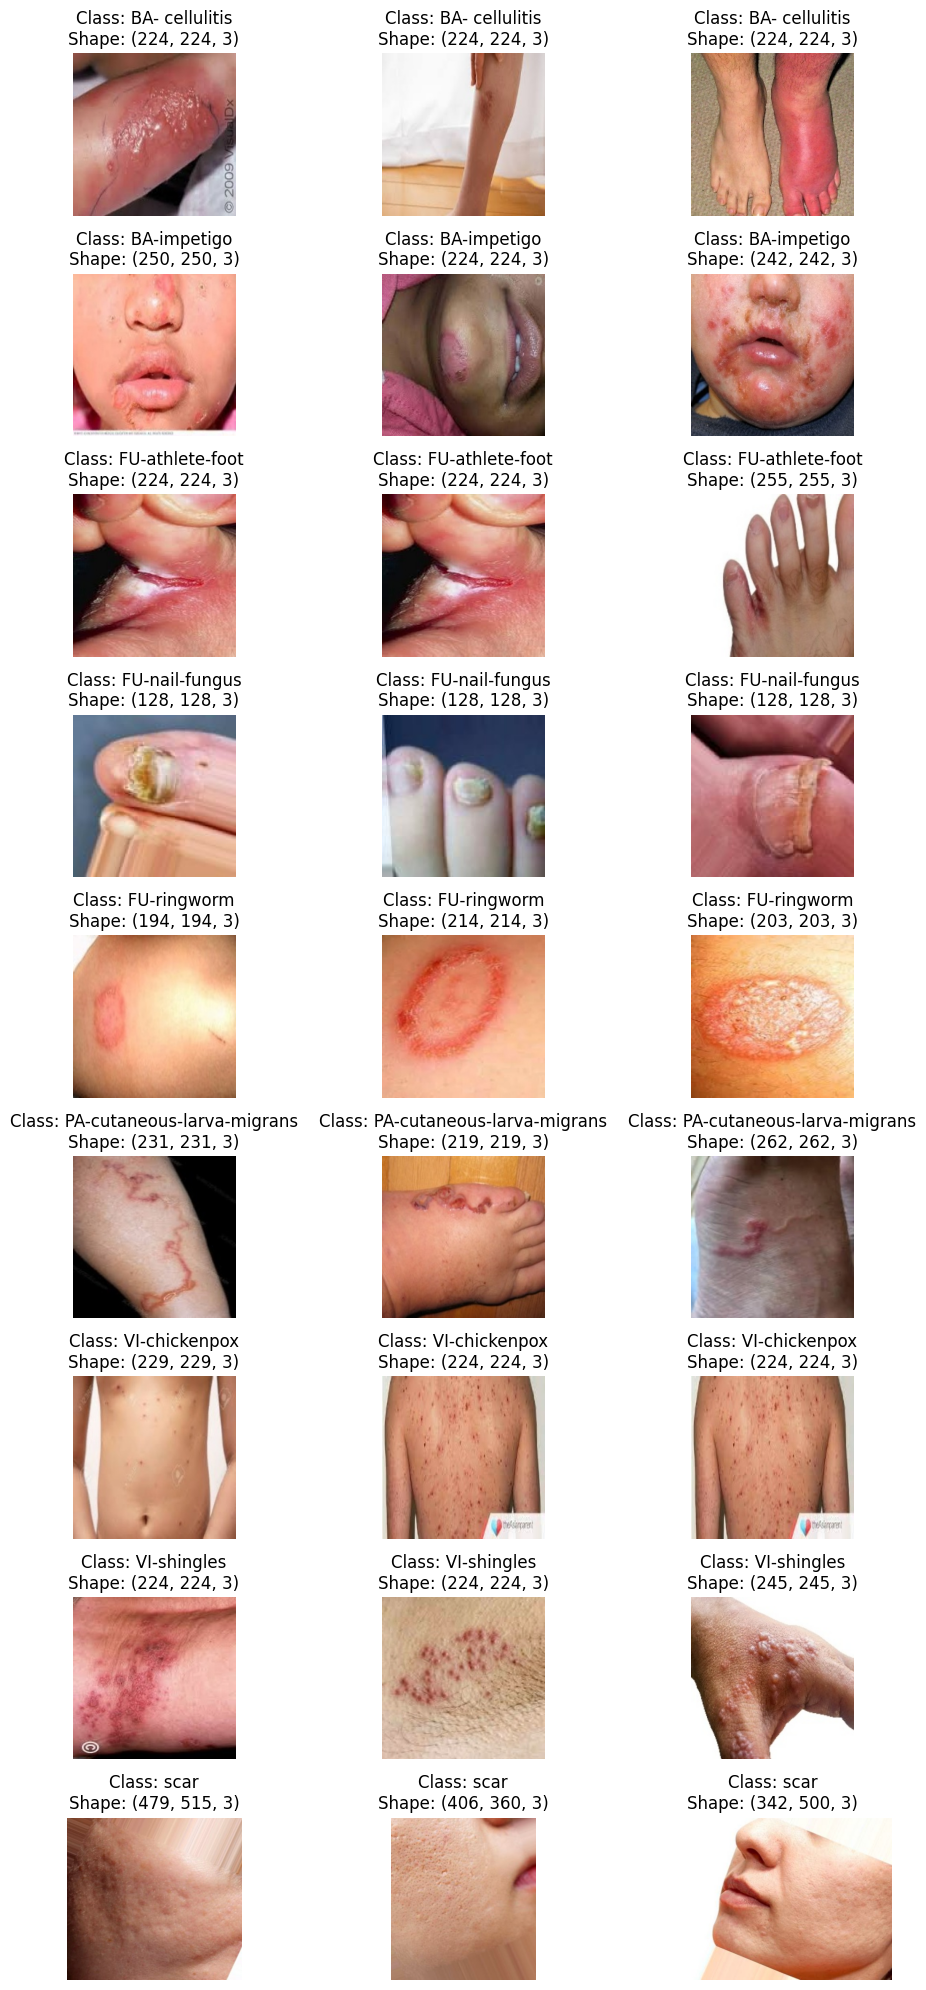

In [ ]:
NUM_OF_IMAGE = 3  # Number of images to generate

# Initialize the figure
fig, ax = plt.subplots(nrows=len(classes), ncols=NUM_OF_IMAGE, figsize=(10, 20))

# Loop through each class
for p, c in enumerate(classes):
    img_path_class = list(Path(os.path.join(train_dir, c)).glob("*.jpg"))
    img_path_class += list(Path(os.path.join(train_dir, c)).glob("*.jpeg"))

    # Check if the number of available images is less than NUM_OF_IMAGE
    if len(img_path_class) < NUM_OF_IMAGE:
        print(f"Warning: Not enough images in class '{c}' to select {NUM_OF_IMAGE} images.")
        img_selected = img_path_class  # Select all available images
    else:
        img_selected = random.choices(img_path_class, k=NUM_OF_IMAGE)

    # Loop through selected images
    for i, j in enumerate(img_selected):
        img_bgr = cv2.imread(str(j))
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        ax[p, i].imshow(img_rgb)
        ax[p, i].set_title(f"Class: {c}\nShape: {img_rgb.shape}")
        ax[p, i].axis('off')

fig.tight_layout()
plt.show()

## Building the Model

In [ ]:

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 128)       0

## Model V2 Transferlearning mobilenetv2

In [ ]:
IMG_SHAPE = (224, 224, 3)

base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

17225924/17225924 [==============================] - 2s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(9, activation='softmax')
])

model.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
              metrics = ['acc'])

In [ ]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                  monitor='val_acc', mode='max',
                                                 verbose=1)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      if logs.get('val_loss')<0.001:
          self.model.stop_training = True
callback2 = myCallback()

In [ ]:
from collections import Counter
counter = Counter(train_generator.classes)
max_val = float(max(counter.values()))
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}

In [ ]:
history = model.fit(train_generator,
                    epochs=15,
                    class_weight=class_weights,
                    callbacks=[learning_rate_reduction, callback, callback2],
                    validation_data=validation_generator)

Epoch 1/15
104/106 [============================>.] - ETA: 0s - loss: 1.3164 - acc: 0.6365
Epoch 1: saving model to best_model.h5
106/106 [==============================] - 8s 34ms/step - loss: 1.2981 - acc: 0.6424 - val_loss: 0.5028 - val_acc: 0.8615 - lr: 0.0010
Epoch 2/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


105/106 [============================>.] - ETA: 0s - loss: 0.4134 - acc: 0.9160
Epoch 2: saving model to best_model.h5
106/106 [==============================] - 3s 33ms/step - loss: 0.4112 - acc: 0.9167 - val_loss: 0.3346 - val_acc: 0.8923 - lr: 0.0010
Epoch 3/15
104/106 [============================>.] - ETA: 0s - loss: 0.2557 - acc: 0.9508
Epoch 3: saving model to best_model.h5
106/106 [==============================] - 3s 27ms/step - loss: 0.2542 - acc: 0.9518 - val_loss: 0.2408 - val_acc: 0.9385 - lr: 0.0010
Epoch 4/15
105/106 [============================>.] - ETA: 0s - loss: 0.1724 - acc: 0.9733
Epoch 4: saving model to best_model.h5
106/106 [==============================] - 3s 24ms/step - loss: 0.1720 - acc: 0.9726 - val_loss: 0.2145 - val_acc: 0.9346 - lr: 0.0010
Epoch 5/15
105/106 [============================>.] - ETA: 0s - loss: 0.1205 - acc: 0.9914
Epoch 5: saving model to best_model.h5
106/106 [==============================] - 4s 39ms/step - loss: 0.1203 - acc: 0.9915 -

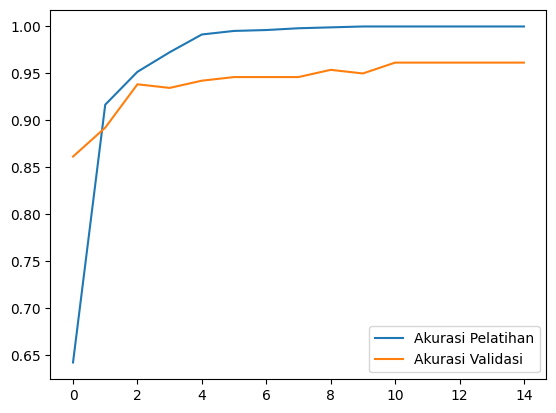

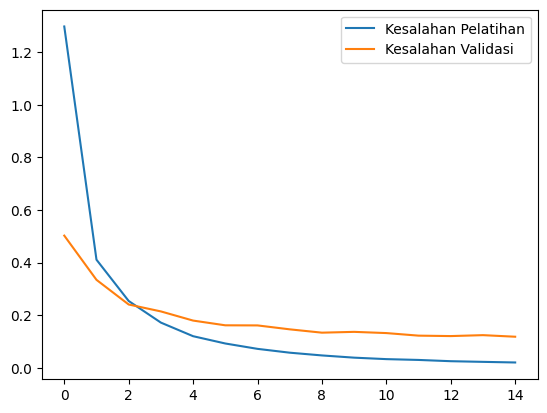

In [ ]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Akurasi Validasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Kesalahan Validasi")
plt.legend()
plt.show()

## Model Testing

In [ ]:
import keras
from keras.utils import to_categorical

# Assuming y_test is already defined
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test, y_test2)


In [ ]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data training
print(model.evaluate(train_generator))
#Evaluasi validasi data
print(model.evaluate(validation_generator))
#Evaluasi data test
print(model.evaluate(x= X_test3, y = y_test3))

['loss', 'acc']
106/106 [==============================] - 2s 22ms/step - loss: 0.0129 - acc: 1.0000
[0.012873963452875614, 1.0]
26/26 [==============================] - 1s 19ms/step - loss: 0.1183 - acc: 0.9615
[0.11831185966730118, 0.9615384340286255]
9/9 [==============================] - 2s 96ms/step - loss: 0.1285 - acc: 0.9540
[0.12850220501422882, 0.954023003578186]


Confusion Matrix

In [ ]:
y_true=np.argmax(y_test2,axis=1)
Y_pred=model.predict(X_test)
y_pred=np.argmax(Y_pred,axis=1)

9/9 [==============================] - 1s 43ms/step


Normalized confusion matrix
[[0.94 0.   0.   0.03 0.03 0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.94 0.   0.   0.06 0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.09 0.   0.   0.   0.91 0.   0.   0.   0.  ]
 [0.   0.   0.08 0.   0.   0.88 0.   0.04 0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.03 0.   0.97 0.  ]
 [0.   0.04 0.   0.   0.   0.   0.   0.04 0.93]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8]


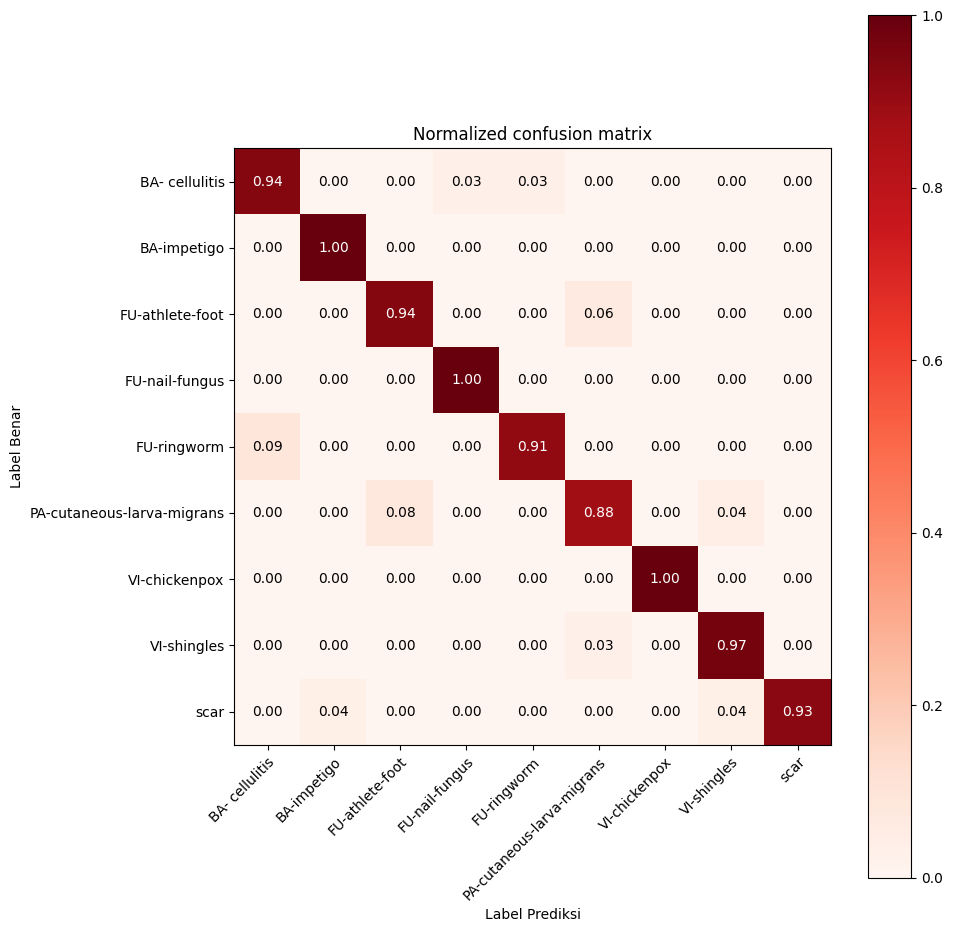

In [ ]:
#cobafrom sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Label Benar',
           xlabel='Label Prediksi')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')
print(y_test)

Demo Model Prediction Result

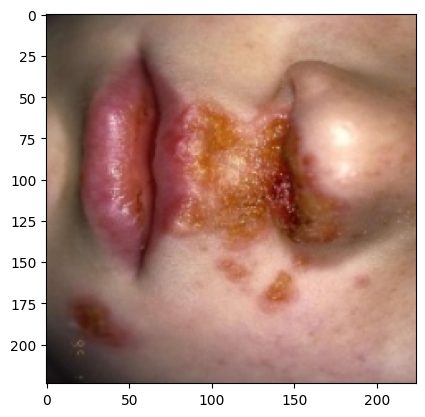

Label yang benar adalah: 1 : BA-impetigo
1/1 [==============================] - 0s 29ms/step
Nilai yang diprediksi adalah: [3.39e-07 9.99e-01 4.85e-05 3.28e-07 1.22e-06 1.29e-03 5.30e-05 6.16e-05
 1.81e-06]
Label yang diprediksi adalah: 1 : BA-impetigo
Prediksi benar


In [ ]:
n = 35 #Jangan melampaui jumlah gambar test sebanyak 260 gambar (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")

## Converting to H5 and Json

In [ ]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 87.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 102.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 110.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 95.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 108.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 37.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
  

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the H5 model
model = load_model('best_model.h5')

# Save the model in TensorFlow SavedModel format
model.save('saved_model')

TypeError: <class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv1_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 32]}, 'name': 'conv1_bn', 'inbound_nodes': [[['conv1', 0, 0, {}]]]}.

Exception encountered: Error when deserializing class 'BatchNormalization' using config={'name': 'conv1_bn', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}.

Exception encountered: int() argument must be a string, a bytes-like object or a real number, not 'list'

In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model saved_model tfjs_model

2024-06-08 12:11:11.049265: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 959, in pip_main
    main([' '.join(sys.argv[1:])])
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 963, in main
    convert(argv[0].split(' '))
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 949, in convert
    _dispatch_converter(input_format, output_format, args, quantization_dtype_map,
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 655, in _dispatch_converter
    tf_saved_model_conversion_v2.convert_tf_saved_model(
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/tf_saved_model_conversion_v

In [ ]:
import zipfile
import os

# Path to the directory containing your .bin and JSON files
directory = '/content/'

# List all files in the directory
files = os.listdir(directory)

# Filter out .bin and .json files
files_to_zip = [f for f in files if f.endswith('.bin') or f.endswith('.json')]

# Define the name for your zip file
zip_file_name = 'model_files_fix_mu.zip'

# Path to save the zip file
zip_file_path = '/content/' + zip_file_name

# Create a zip file
with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    # Add each file to the zip
    for file in files_to_zip:
        zipf.write(os.path.join(directory, file), file)

print("Zip file created successfully:", zip_file_path)

Zip file created successfully: /content/model_files_fix_mu.zip
